<a href="https://colab.research.google.com/github/a-n-u-r-a-g/Protecting-FinTech-Platforms-from-Advanced-Persistent-Threats-and-Financial-Data-Breaches/blob/main/IEEE_CIS_Transaction_level_fraud_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost xgboost lightgbm scikit-learn seaborn matplotlib --quiet


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score, roc_curve
)

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier


In [ ]:
# Load the datasets
tx = pd.read_csv('/content/train_transaction.csv')
idn = pd.read_csv('/content/train_identity.csv')

# Merge both datasets on the 'TransactionID' column
df2 = tx.merge(idn, on='TransactionID', how='left')
print("Merged shape:", df2.shape)
df2.head()


Merged shape: (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
# Optimize memory usage
def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:3] != 'dat':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df

df2 = reduce_memory(df2)


<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
<ipython-input-7-c32c0c92d712>:16: RuntimeWarning: overflow enco

In [ ]:
# Drop columns with more than 80% missing
df2 = df2.loc[:, df2.isnull().mean() < 0.8]


In [ ]:
# Encode object types as integers (label encoding)
for col in df2.select_dtypes(include='object').columns:
    df2[col] = df2[col].astype('category').cat.codes


In [ ]:
df2 = df2.sample(frac=0.5, random_state=42)  # use only 50% of the data


In [ ]:
from sklearn.preprocessing import StandardScaler

X2 = df2.drop(columns=['TransactionID', 'isFraud'], errors='ignore')
y2 = df2['isFraud']

scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_scaled, y2, test_size=0.2, stratify=y2, random_state=42
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Initialize models
rf2   = RandomForestClassifier(n_jobs=-1, random_state=42)
xgb2  = XGBClassifier(eval_metric='logloss', use_label_encoder=False, n_jobs=-1)
lgbm2 = LGBMClassifier(n_jobs=-1)
cat2  = CatBoostClassifier(verbose=0)

# Train models
for model in [rf2, xgb2, lgbm2, cat2]:
    model.fit(X2_train, y2_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:30:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 8349, number of negative: 227867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.506610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31693
[LightGBM] [Info] Number of data points in the train set: 236216, number of used features: 357
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035345 -> initscore=-3.306620
[LightGBM] [Info] Start training from score -3.306620


In [ ]:
import numpy as np

# Get probabilities
p2 = np.vstack([
    rf2.predict_proba(X2_test)[:, 1],
    xgb2.predict_proba(X2_test)[:, 1],
    lgbm2.predict_proba(X2_test)[:, 1],
    cat2.predict_proba(X2_test)[:, 1]
]).T

# Average probability and binary prediction
y2_proba = p2.mean(axis=1)
y2_pred = (y2_proba >= 0.5).astype(int)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import seaborn as sns
import matplotlib.pyplot as plt

# Metrics
acc2   = accuracy_score(y2_test, y2_pred)
prec2  = precision_score(y2_test, y2_pred)
rec2   = recall_score(y2_test, y2_pred)
f12    = f1_score(y2_test, y2_pred)
roc2   = roc_auc_score(y2_test, y2_proba)

print("📊 IEEE-CIS Ensemble Metrics")
print(f"Accuracy:  {acc2:.4f}")
print(f"Precision: {prec2:.4f}")
print(f"Recall:    {rec2:.4f}")
print(f"F1-Score:  {f12:.4f}")
print(f"ROC-AUC:   {roc2:.4f}\n")

print("Classification Report:\n", classification_report(y2_test, y2_pred))


📊 IEEE-CIS Ensemble Metrics
Accuracy:  0.9800
Precision: 0.9450
Recall:    0.4609
F1-Score:  0.6196
ROC-AUC:   0.9436

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     56967
           1       0.94      0.46      0.62      2087

    accuracy                           0.98     59054
   macro avg       0.96      0.73      0.80     59054
weighted avg       0.98      0.98      0.98     59054



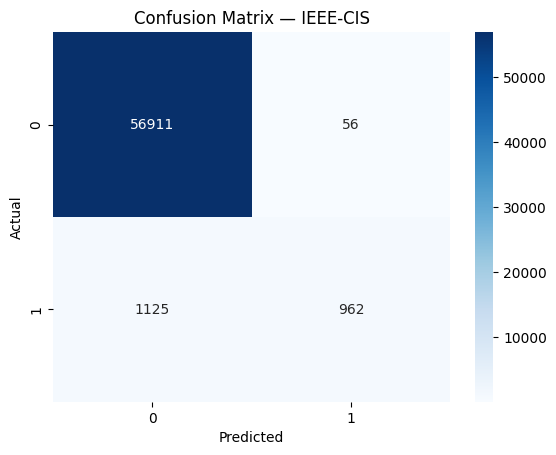

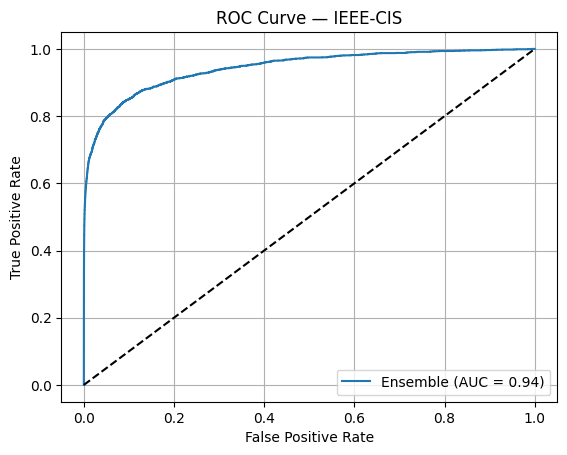

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y2_test, y2_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — IEEE-CIS")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr2, tpr2, _ = roc_curve(y2_test, y2_proba)
plt.plot(fpr2, tpr2, label=f"Ensemble (AUC = {roc2:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve — IEEE-CIS")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [ ]:
def alert_fin(prob, th=0.5):
    return "🚨 Financial Fraud" if prob >= th else "✅ Legitimate"

# Example usage
print("Example alert:", alert_fin(y2_proba[0]))


Example alert: ✅ Legitimate
